## Mesh convergence study

In [1]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.base import advection
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

import tree_math

In [10]:
def makePath(which,dim1,dim2):
    return "./../sims_50_seconds/{}_{:.0f}x{:.0f}.nc".format(which,dim1,dim2)


paths = {
    "dns_2048x512" : makePath("dns",2048,512),
    "dns_1024x256" : makePath("dns",1024,256),
    "dns_256x64" : makePath("dns",256,64),
    "dns_64x16" : makePath("dns",64,16),

}

In [11]:
models = paths.keys()

datasets = {}
for model in models:
    datasets[model] = xarray.open_dataset(paths[model], chunks={'time': '100MB'})

In [19]:
def sampling(data,factor):
    return data[:,0::factor,0::factor]

In [13]:
def myMse(data1,data2):    
    return np.mean((data1-data2)**2)

def myMape(data1,data2):
#     print(np.shape((data1-data2)))
#     print(np.shape(data1))
    return np.mean(np.abs((data1-data2)/data1))

In [14]:
def extractData(ds,factor=None):
    u = ds.u.values
    v = ds.v.values
    
    if factor is not None:
        u = sampling(u,factor)
        v = sampling(v,factor)
    
    out = []
    times,_,_ = np.shape(u)
    for time in range(times):
        
        out.append(np.stack([u[time,:,:],v[time,:,:]]))
    
    
    return out

In [15]:
def calculateErrors(reference,referenceFactor,otherSim,otherFactor):
    reference = extractData(reference,referenceFactor)
    otherSim = extractData(otherSim,otherFactor)
    
    (times,_,_,_) = np.shape(reference)
    errors = []
    for time in range(times):
#         print(time)
        errors.append(myMse(reference[time][:,:,:],otherSim[time][:,:,:]))
#         errors.append(myMape(reference[time][:,:,:],otherSim[time][:,:,:]))
    
    return errors

In [55]:
errors = {}

errors["2048x512"] = calculateErrors(datasets["dns_2048x512"],None,datasets["dns_2048x512"],None)
errors["1024x256"] = calculateErrors(datasets["dns_2048x512"],2,datasets["dns_1024x256"],None)
errors["256x64"] = calculateErrors(datasets["dns_2048x512"],8,datasets["dns_256x64"],None)
errors["64x16"] = calculateErrors(datasets["dns_2048x512"],32,datasets["dns_64x16"],None)


In [56]:
mykeys = errors.keys()

for key in mykeys:
    thislist = errors[key]
    for i in range(len(errors[key])):
        thislist[i] = -thislist[i]
    errors[key] = thislist

In [57]:
time = datasets["dns_1024x256"].time.values
time

array([10., 20., 30., 40., 50.])

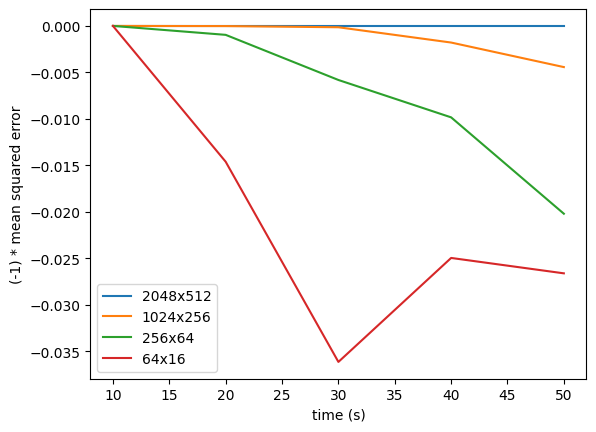

In [60]:
mykeys = errors.keys()

for key in mykeys:
    plt.plot(time,errors[key],label=key)

# plt.plot(time,errors_LI_256x64,'-gx',label="LI 256x64")
# plt.plot(time,errors_LI_64x16,'-go',label="LI 64x16")

# plt.plot(time,errors_DNS_256x64,'-bx',label="DNS 256x64")
# plt.plot(time,errors_DNS_64x16,'-bo',label="DNS 64x16")
plt.xlabel("time (s)")
plt.ylabel("(-1) * mean squared error")
plt.legend()
# plt.ylim([0,10000])
# plt.xlim([40,50])